In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *
from encoding_information.plot_utils import *

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-12-06 14:23:37.586782: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 14:23:38.292539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


In [2]:


def plot_and_print_analysis(initial_likelihood, optimized_likelihood,
                            samples_initial, samples_optimized, 
                            cov_mat_initial, cov_mat_optimized, patch_size, num_samples):

    print(f'Initial likelihood: {initial_likelihood}')
    print(f'Optimized likelihood: {optimized_likelihood}')


    fig, axs = plt.subplots(2, num_samples, figsize=(num_samples * 3, 4), sharex=True, sharey=True)
    vmin_optimized, vmax_optimized = np.percentile(samples_optimized, .1), np.percentile(samples_optimized, 99.9)
    for i in range(num_samples):
        im1 = axs[0, i].imshow(samples_initial[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
        im2 = axs[1, i].imshow(samples_optimized[i], cmap='inferno', vmin=vmin_optimized, vmax=vmax_optimized)
        axs[0, i].axis('off')
        axs[1, i].axis('off')

    axs[0, 0].set_title('Initial')
    axs[1, 0].set_title('Optimized')

    # add colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im1, cax=cbar_ax)
    cbar_ax.set_ylabel('Photons')

    sample_size = samples_optimized.shape[1] * samples_optimized.shape[2]
    fig.suptitle(f'Sample size: {sample_size}, patch_size: {patch_size}')

    # plot eignevalues of different cov mats
    eig_vals_initial = np.linalg.eigvalsh(cov_mat_initial)
    eig_vals_optimized = np.linalg.eigvalsh(cov_mat_optimized)

    fig, axs = plt.subplots(1, 1, figsize=(4, 4))
    axs.semilogy(eig_vals_initial, label='initial')
    axs.semilogy(eig_vals_optimized, label='optimized')
    axs.legend()

    clear_spines(axs)
    axs.set_xlabel('Eigenvalue index')
    axs.set_ylabel('Eigenvalue')

In [3]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0, verbose=True)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed, verbose=True)


100%|██████████| 10000/10000 [03:11<00:00, 52.17it/s]


2023-12-06 14:29:06.596479: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


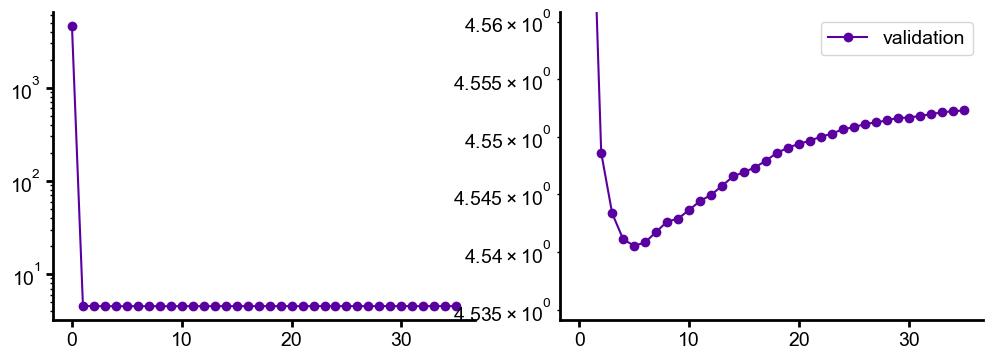

In [4]:
from encoding_information.models.gaussian_process import StationaryGaussianProcess

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)
val_loss_history = gp.fit(patches, num_val_samples=1000, max_epochs=1000, patience=30, verbose=False)
plot_optimization_loss_history(val_loss_history)

## Show the covariance matrix

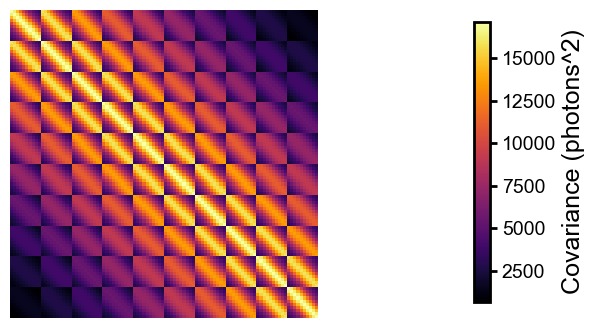

In [11]:
cov_mat = gp.get_cov_mat()

fig, axs = plt.subplots(1, 1, figsize=(8, 4))
im = axs.imshow(cov_mat, cmap='inferno', interpolation='none')
axs.set_axis_off()

# make a colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Covariance (photons^2)')

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/example_cov_mat.pdf', transparent=True)


precomputing masks and variances: 100%|██████████| 40/40 [00:38<00:00,  1.03it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 182.53it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 40/40 [00:37<00:00,  1.07it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 203.99it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 176.18it/s]


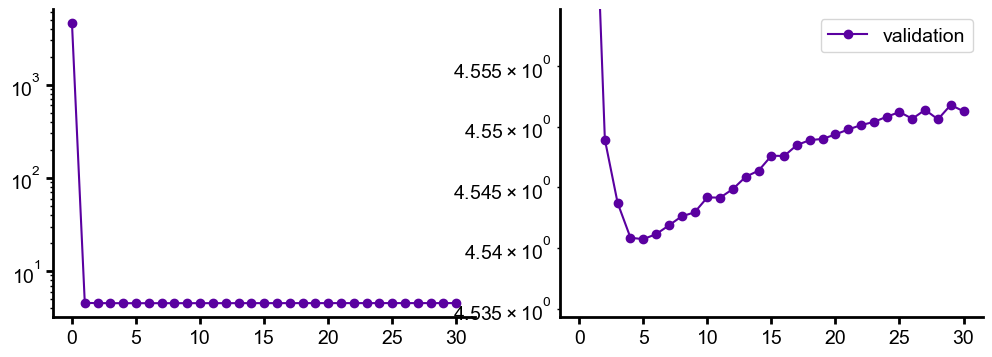

In [18]:
sample_size = 40
num_samples = 8

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)

samples_initial = gp.generate_samples(num_samples=num_samples, sample_size=sample_size, seed=None)
nll_initial = gp.compute_negative_log_likelihood(test_patches)
cov_mat_initial = gp.get_cov_mat()

# fit it with early stopping
val_loss_history = gp.fit(patches, num_val_samples=1000, max_epochs=1000, patience=25, verbose=False)
samples_optimized = gp.generate_samples(num_samples=num_samples, sample_size=sample_size, seed=None)
nll_optimized = gp.compute_negative_log_likelihood(test_patches)
cov_mat_optimized = gp.get_cov_mat()

plot_optimization_loss_history(val_loss_history)

Initial likelihood: 4671.057957715011
Optimized likelihood: 4.554505822443067


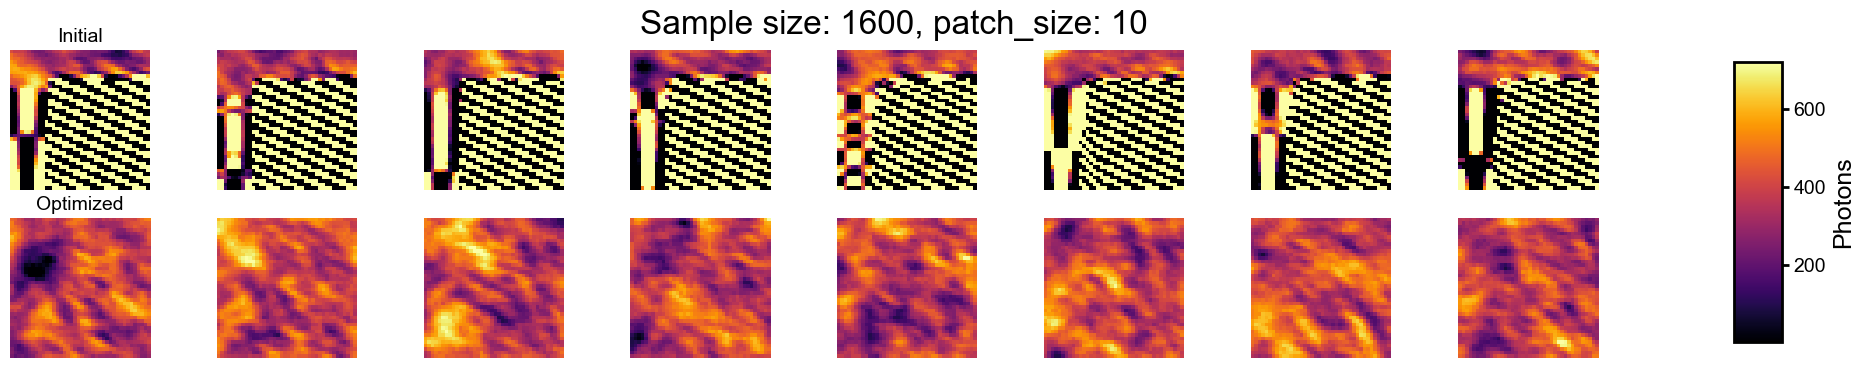

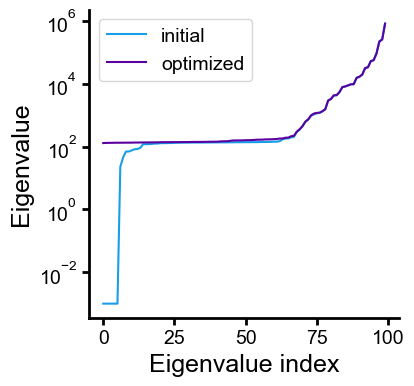

In [21]:

plot_and_print_analysis(nll_initial, nll_optimized,
                            samples_initial, samples_optimized,
                            cov_mat_initial, cov_mat_optimized, patch_size, num_samples)

## Does DPC produce the same artifacts? 

In [22]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'DPC_Right'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0, verbose=True)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed, verbose=True)

100%|██████████| 10000/10000 [01:55<00:00, 86.57it/s]


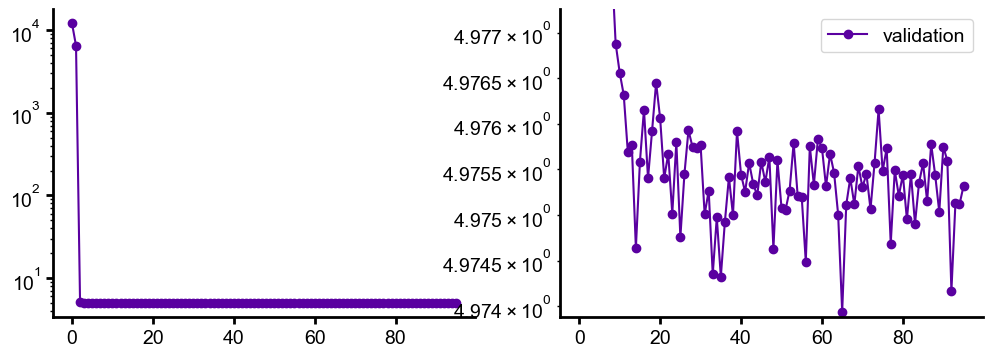

In [23]:

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)
val_loss_history = gp.fit(patches, num_val_samples=1000, max_epochs=1000, patience=30, verbose=False)
plot_optimization_loss_history(val_loss_history)

precomputing masks and variances:   0%|          | 0/40 [00:00<?, ?it/s]

precomputing masks and variances: 100%|██████████| 40/40 [00:37<00:00,  1.08it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 175.16it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 40/40 [00:38<00:00,  1.05it/s]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 190.76it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 168.52it/s]


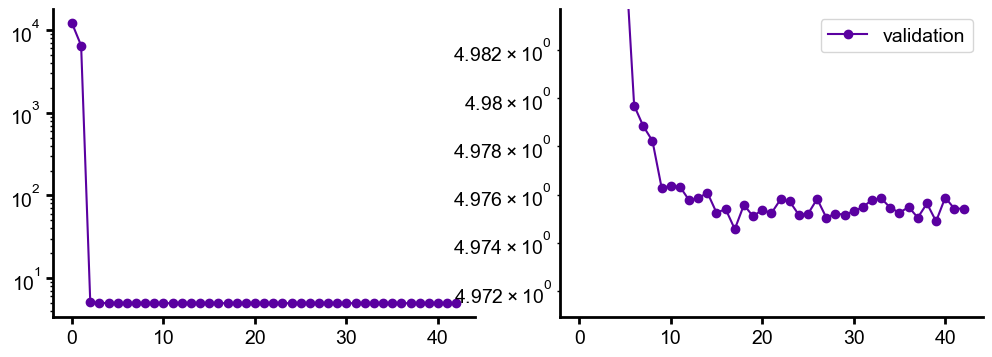

In [24]:
sample_size = 40
num_samples = 8

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)

samples_initial = gp.generate_samples(num_samples=num_samples, sample_size=sample_size, seed=None)
nll_initial = gp.compute_negative_log_likelihood(test_patches)
cov_mat_initial = gp.get_cov_mat()

# fit it with early stopping
val_loss_history = gp.fit(patches, num_val_samples=1000, max_epochs=1000, patience=25, verbose=False)
samples_optimized = gp.generate_samples(num_samples=num_samples, sample_size=sample_size, seed=None)
nll_optimized = gp.compute_negative_log_likelihood(test_patches)
cov_mat_optimized = gp.get_cov_mat()

plot_optimization_loss_history(val_loss_history)

Initial likelihood: 11751.271064049566
Optimized likelihood: 4.965953932238841


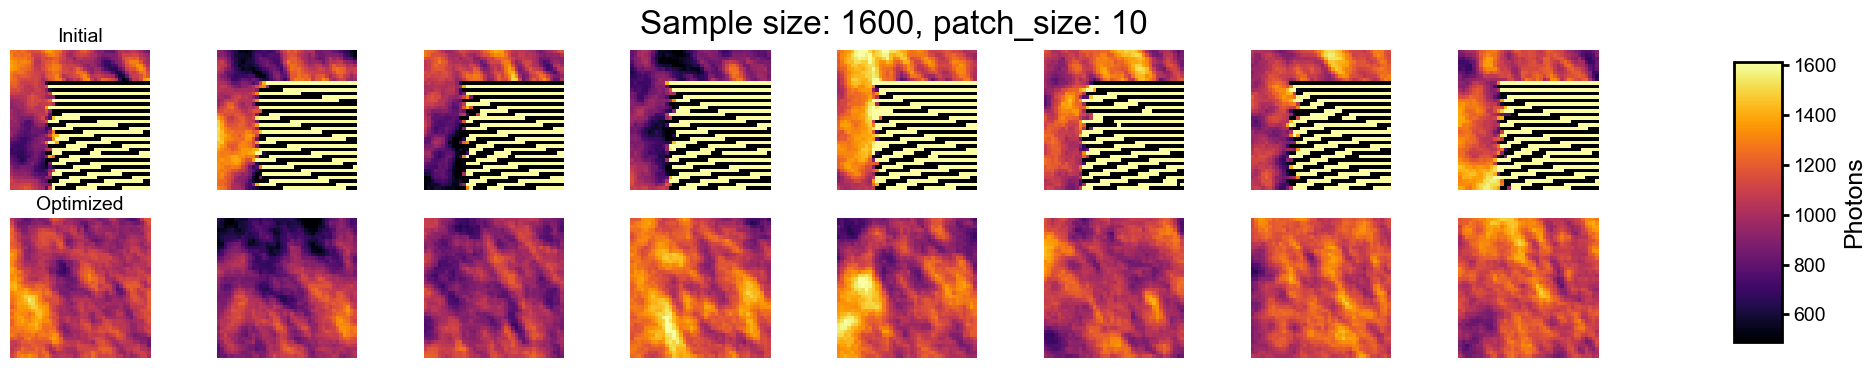

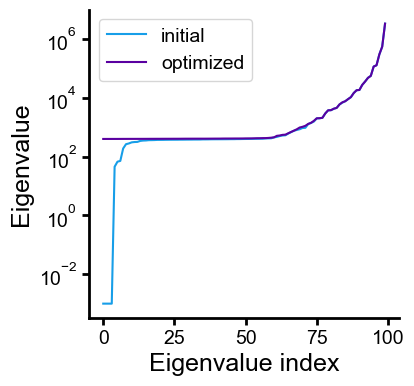

In [25]:
plot_and_print_analysis(nll_initial, nll_optimized,
                            samples_initial, samples_optimized,
                            cov_mat_initial, cov_mat_optimized, patch_size, num_samples)

## Can you generate an even bigger patch?

In [26]:
# load images, extract patches, and compute cov mats
edge_crop = 32
patch_size = 10
num_images = 20000
channel = 'LED119'
eigenvalue_floor = 1e-3

num_test_images = 1000

all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_images, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_images = all_images[num_images:]
test_patches = extract_patches(test_images, patch_size, num_patches=num_test_images, seed=0)

num_patches = 10000 
seed = 10 # this seed gives a bad initial fit
patches = extract_patches(images, patch_size, num_patches=num_patches, seed=seed)


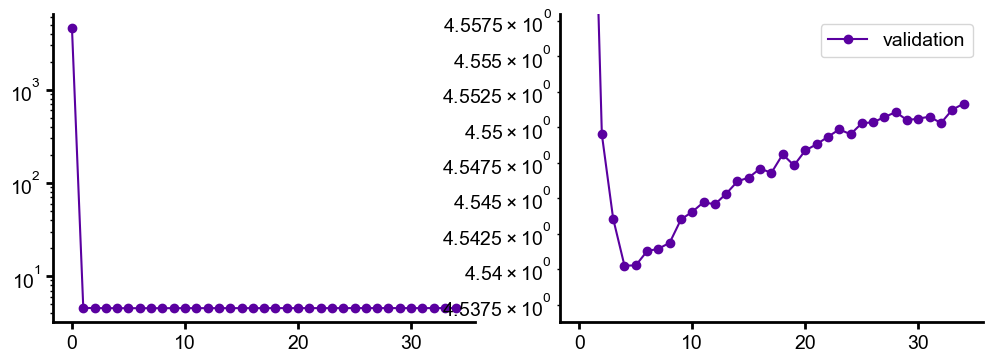

In [27]:

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)
val_loss_history = gp.fit(patches, num_val_samples=1000, max_epochs=1000, patience=30, verbose=False)
plot_optimization_loss_history(val_loss_history)

precomputing masks and variances: 100%|██████████| 100/100 [04:31<00:00,  2.72s/it]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 189.32it/s]


evaluating likelihood


precomputing masks and variances: 100%|██████████| 100/100 [04:10<00:00,  2.50s/it]


generating samples


precomputing masks and variances: 100%|██████████| 10/10 [00:00<00:00, 199.26it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 10/10 [00:00<00:00, 194.34it/s]


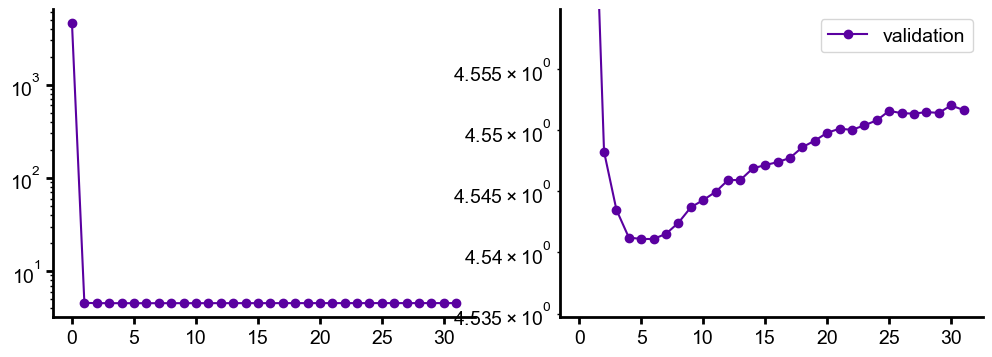

In [29]:
sample_size = 100
num_samples = 8

gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)

samples_initial = gp.generate_samples(num_samples=num_samples, sample_size=sample_size, seed=None)
nll_initial = gp.compute_negative_log_likelihood(test_patches)
cov_mat_initial = gp.get_cov_mat()

# fit it with early stopping
val_loss_history = gp.fit(patches, num_val_samples=1000, max_epochs=1000, patience=25, verbose=False)
samples_optimized = gp.generate_samples(num_samples=num_samples, sample_size=sample_size, seed=None)
nll_optimized = gp.compute_negative_log_likelihood(test_patches)
cov_mat_optimized = gp.get_cov_mat()

plot_optimization_loss_history(val_loss_history)

Initial likelihood: 4671.057957715011
Optimized likelihood: 4.554584112411551


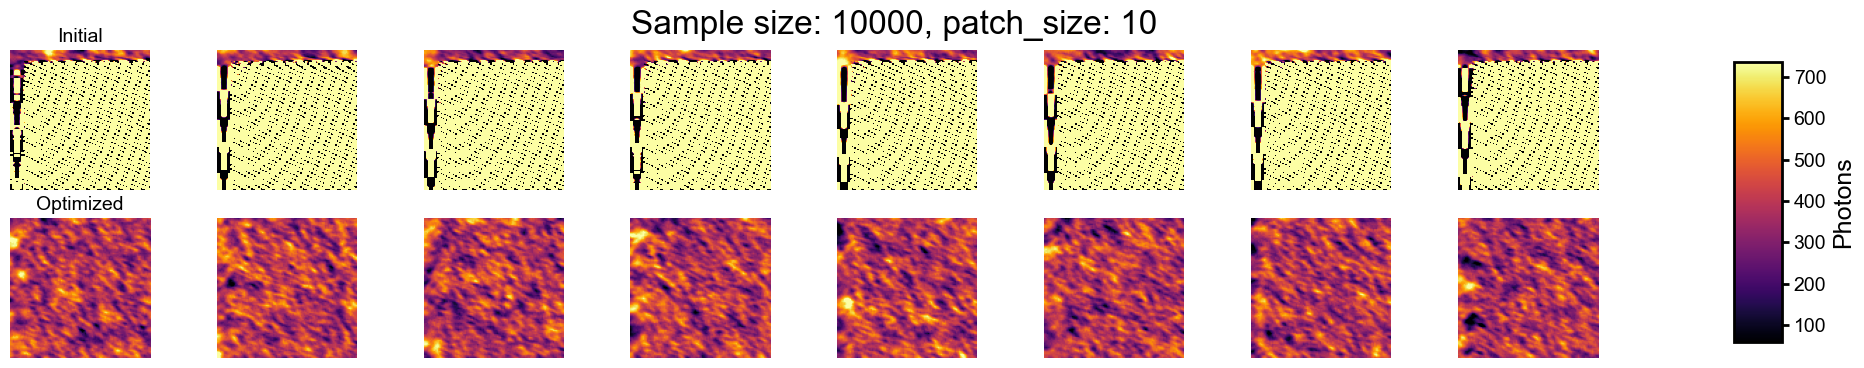

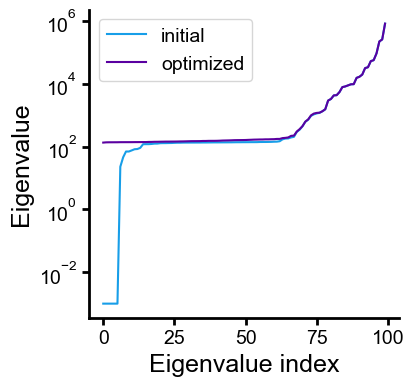

In [30]:
plot_and_print_analysis(nll_initial, nll_optimized,
                            samples_initial, samples_optimized,
                            cov_mat_initial, cov_mat_optimized, patch_size, num_samples)